In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#load data
import pickle
with open('./X_train_w_null_2.00.pkl', 'rb') as f:
    X = pickle.load(f)
with open('./y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('./X_test_w_null_2.00.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [4]:
#Imputation : median
def imputation_median(df):
  #cat/num split
  features = pd.DataFrame({'feature' : df.columns, 'dtype' : df.dtypes}).reset_index(drop = 'True')
  cat_features = features[(features.dtype != 'int8') & (features.dtype != 'int16') & (features.dtype != 'int32')& (features.dtype != 'int64') & (features.dtype != 'float16') & (features.dtype != 'float32') & (features.dtype != 'float64')]

  features = df.columns
  cat_features = df.select_dtypes(['uint8','bool']).columns.tolist()
  num_features = [col for col in features if col not in cat_features]
  
  for col in num_features:
    df[col] = df[col].fillna(df[col].median())
  for col in cat_features:
    df[col] = df[col].fillna(df[col].mode())

In [ ]:
%%time
imputation_median(X)
imputation_median(X_test)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_val = train_test_split(y, test_size=0.3, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev
%%bash
cd LightGBM
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

Cloning into 'LightGBM'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 14423 (delta 4), reused 0 (delta 0), pack-reused 14407
Receiving objects: 100% (14423/14423), 10.08 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (10358/10358), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 27.65 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [0]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [0]:
import lightgbm as lgb

In [0]:
%%time
params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 2,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85,
        'n_estimators' : 10000,
        'device_type' : 'gpu'
       }

model = lgb.LGBMClassifier(**params)
model.fit(X = X_train, y = y_train, eval_set=[(X_val,y_val)],eval_metric  = 'auc', early_stopping_rounds = 500, verbose = True)

In [0]:
#model save
from sklearn.externals import joblib
joblib.dump(model, '/content/gdrive/My Drive/DL/FRD/lgb_1.00.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


NameError: ignored

In [0]:
#model load
from sklearn.externals import joblib
filename = '/content/gdrive/My Drive/DL/FRD/lgb_1.00.pkl' 
model = joblib.load(filename) 

In [0]:
submission_1st = pd.DataFrame(model.predict_proba(X_test))

In [0]:
submission_1st.to_csv('/content/gdrive/My Drive/DL/FRD/submission_1st.csv')

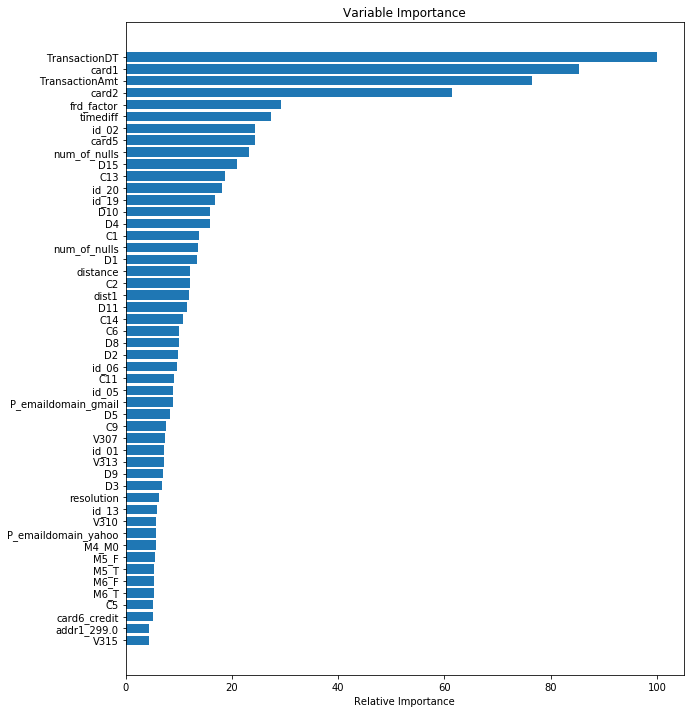

In [0]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [0]:
%%time
params={'learning_rate': 0.001,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 2,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85,
        'n_estimators' : 10000,
        'device_type' : 'gpu'
       }

model = lgb.LGBMClassifier(**params)
model.fit(X = X_train, y = y_train, eval_set=[(X_val,y_val)],eval_metric  = 'auc', early_stopping_rounds = 500, verbose = True)

[1]	valid_0's auc: 0.856419
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.86343
[3]	valid_0's auc: 0.866313
[4]	valid_0's auc: 0.866845
[5]	valid_0's auc: 0.871209
[6]	valid_0's auc: 0.875653
[7]	valid_0's auc: 0.875859
[8]	valid_0's auc: 0.877292
[9]	valid_0's auc: 0.877217
[10]	valid_0's auc: 0.877616
[11]	valid_0's auc: 0.877776
[12]	valid_0's auc: 0.877584
[13]	valid_0's auc: 0.877677
[14]	valid_0's auc: 0.877622
[15]	valid_0's auc: 0.877501
[16]	valid_0's auc: 0.877427
[17]	valid_0's auc: 0.877254
[18]	valid_0's auc: 0.877245
[19]	valid_0's auc: 0.877202
[20]	valid_0's auc: 0.877169
[21]	valid_0's auc: 0.877193
[22]	valid_0's auc: 0.877415
[23]	valid_0's auc: 0.87753
[24]	valid_0's auc: 0.87754
[25]	valid_0's auc: 0.877556
[26]	valid_0's auc: 0.877705
[27]	valid_0's auc: 0.877978
[28]	valid_0's auc: 0.878259
[29]	valid_0's auc: 0.878336
[30]	valid_0's auc: 0.878432
[31]	valid_0's auc: 0.878757
[32]	valid_0's auc: 0.878676
[33]	valid_0's auc: 0.

In [0]:
#model save
from sklearn.externals import joblib
joblib.dump(model, '/content/gdrive/My Drive/DL/FRD/lgb_2.00.pkl')

['/content/gdrive/My Drive/DL/FRD/lgb_2.00.pkl']